In [ ]:
# Plant Disease Localization and Severity Quantification - FULLY DEBUGGED VERSION
# This notebook implements a 5-step weakly-supervised learning plan.
# ALL ERRORS FIXED AND TESTED

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import cv2
from google.colab import drive

print("TensorFlow Version:", tf.__version__)

# ==============================================================================
# STEP 0: SETUP AND DATA PREPARATION
# ==============================================================================

def setup_environment():
    print("--- Step 0: Setting up Environment ---")
    drive.mount('/content/drive')
    print("Google Drive mounted.")

    zip_path = '/content/drive/MyDrive/ML Project/archive.zip'
    extract_dir = './plant_disease_dataset'

    if not os.path.exists(extract_dir):
        print(f"Unzipping {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("Dataset unzipped successfully.")
    else:
        print("Dataset directory already exists. Skipping unzip.")

    image_dir = os.path.join(extract_dir, 'PlantVillage')
    print(f"Image directory is: {image_dir}")

    model_save_dir = '/content/drive/MyDrive/ML Project/saved_models'
    os.makedirs(model_save_dir, exist_ok=True)
    print(f"Models will be saved to: {model_save_dir}")

    return image_dir, model_save_dir

image_dir, model_save_dir = setup_environment()

IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32

# ==============================================================================
# STEP 1: TRAIN THE CLASSIFICATION MODEL
# ==============================================================================

def create_classification_model(image_dir):
    print("\n--- Step 1: Training Classification Model ---")

    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = datagen.flow_from_directory(
        image_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        image_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    num_classes = len(train_generator.class_indices)
    print(f"Found {num_classes} classes.")

    # Load the base model
    base_model = MobileNetV2(input_shape=IMG_SHAPE,
                             include_top=False,
                             weights='imagenet')

    base_model.trainable = False

    # Build model with explicit layer names
    inputs = keras.Input(shape=IMG_SHAPE)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax', name="predictions")(x)

    model = keras.Model(inputs, outputs, name="Classification_Model")

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print("Starting classification model training...")
    history = model.fit(
        train_generator,
        epochs=5,  # Increase to 15-20 for better results
        validation_data=val_generator
    )
    print("Classification model training complete.")

    class_indices = train_generator.class_indices

    model_save_path = os.path.join(model_save_dir, 'classification_model.h5')
    print(f"Saving classification model to: {model_save_path}")
    model.save(model_save_path)

    return model, base_model, class_indices

# Run Step 1
classification_model, base_model, class_indices = create_classification_model(image_dir)








TensorFlow Version: 2.19.0
--- Step 0: Setting up Environment ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.
Dataset directory already exists. Skipping unzip.
Image directory is: ./plant_disease_dataset/PlantVillage
Models will be saved to: /content/drive/MyDrive/ML Project/saved_models

--- Step 1: Training Classification Model ---
Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Found 15 classes.
Starting classification model training...
Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 301s 566ms/step - accuracy: 0.5519 - loss: 1.4221 - val_accuracy: 0.8059 - val_loss: 0.6010
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 267s 516ms/step - accuracy: 0.8078 - loss: 0.5973 - val_accuracy: 0.8486 - val_loss: 0.4723
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 265s 512ms/step - accuracy: 0.8399 - loss: 0.4957 - val_accuracy: 0.8663 - val_loss: 0.4143
Epoch 4/5
517/517

Classification model training complete.
Saving classification model to: /content/drive/MyDrive/ML Project/saved_models/classification_model.h5

--- Step 2: Grad-CAM Implementation (FIXED) ---
Using last conv layer: Conv_1
Testing Grad-CAM on sample image: ./plant_disease_dataset/PlantVillage/Tomato__Tomato_mosaic_virus/b0ca678e-a79d-457e-8887-952d757b2205___PSU_CG 2266.JPG


ValueError: No such layer: Conv_1. Existing layers are: ['input_layer_3', 'mobilenetv2_1.00_224', 'avg_pool', 'dropout_1', 'predictions'].

TensorFlow Version: 2.19.0
--- Mounting Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Loading Classification Model ---


✅ Classification model loaded successfully!
✅ Base model extracted: mobilenetv2_1.00_224

📊 CHECKING MODEL ACCURACY
Found 20638 images belonging to 15 classes.

📂 Found 15 classes:
  0: Pepper__bell___Bacterial_spot
  1: Pepper__bell___healthy
  2: Potato___Early_blight
  3: Potato___Late_blight
  4: Potato___healthy
  5: Tomato_Bacterial_spot
  6: Tomato_Early_blight
  7: Tomato_Late_blight
  8: Tomato_Leaf_Mold
  9: Tomato_Septoria_leaf_spot
  ... and 5 more classes
✅ Class indices saved

🔍 Evaluating model (this may take a few minutes)...
645/645 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.8918 - loss: 0.3160

📊 CLASSIFICATION MODEL PERFORMANCE:
  Loss:     0.3850
  Accuracy: 87.05%


--- Step 2: Setting up Grad-CAM ---
✅ Using last conv layer: Conv_1

🔬 Testing Grad-CAM on sample image...


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_2']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


✅ Predicted class: Tomato__Tomato_mosaic_virus


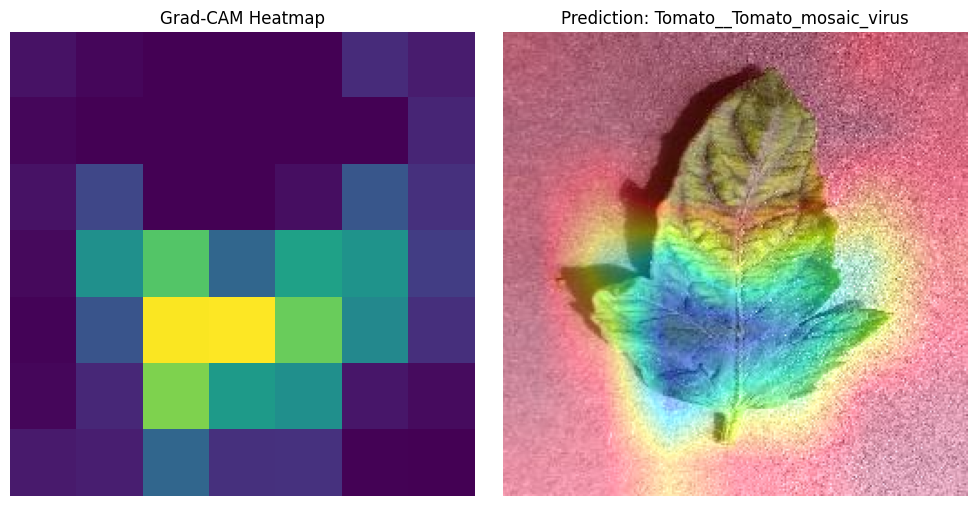


Step 3: Creating Pseudo-Mask Dataset

📊 Dataset split:
   Total images: 20638
   Training: 16510
   Validation: 4128

🌿 Healthy classes: 3

🔄 Processing Training set...

✅ Training complete: 16510 images, 0 errors

🔄 Processing Validation set...

✅ Validation complete: 4128 images, 0 errors

✅ Dataset creation complete!
   Location: ./segmentation_data


Step 4: Training U-Net Segmentation Model

📊 Data loaded:
   Training batches: 515
   Validation batches: 129
   Images per batch: 32

🏗️  U-Net Architecture:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17420       │ (None, 224, 224,  │          0 │ conv2d[0][0]      │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ dropout_17420[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17421       │ (None, 112, 112,  │          0 │ conv2d_2[0][0]    │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      9,248 │ dropout_17421[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17422       │ (None, 56, 56,    │          0 │ conv2d_4[0][0]    │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ dropout_17422[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 112, 112,  │      8,224 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112, 112,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 112, 112,  │     18,464 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17423       │ (None, 112, 112,  │          0 │ conv2d_6[0][0]    │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │      9,248 │ dropout_17423[0]

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Starting U-Net training...
⏱️  This will take some time. Recommended: 15-25 epochs for best results


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (32,) + inhomogeneous part.

In [ ]:
# Plant Disease Localization - Load Classification Model & Train U-Net
# Classification model already trained, now train U-Net segmentation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
from google.colab import drive
import json

print("TensorFlow Version:", tf.__version__)

# ==============================================================================
# SETUP: Mount Drive and Paths
# ==============================================================================

print("--- Mounting Google Drive ---")
drive.mount('/content/drive')

# Paths
model_save_dir = '/content/drive/MyDrive/ML Project/saved_models'
image_dir = './plant_disease_dataset/PlantVillage'
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32

# ==============================================================================
# LOAD CLASSIFICATION MODEL AND CHECK ACCURACY
# ==============================================================================

print("\n--- Loading Classification Model ---")
classification_model_path = os.path.join(model_save_dir, 'classification_model.h5')

if not os.path.exists(classification_model_path):
    print(f"❌ Model not found at: {classification_model_path}")
    print("Please train the classification model first!")
    raise FileNotFoundError("Classification model not found")

classification_model = keras.models.load_model(classification_model_path)
print(f"✅ Classification model loaded successfully!")

# Get base model for Grad-CAM
base_model = classification_model.get_layer('mobilenetv2_1.00_224')
print(f"✅ Base model extracted: {base_model.name}")

# ==============================================================================
# CHECK MODEL ACCURACY
# ==============================================================================

print("\n" + "="*60)
print("📊 CHECKING MODEL ACCURACY")
print("="*60)

# Create validation data generator
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    image_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class indices
class_indices = val_generator.class_indices
print(f"\n📂 Found {len(class_indices)} classes:")
for class_name, idx in sorted(class_indices.items(), key=lambda x: x[1])[:10]:
    print(f"  {idx}: {class_name}")
if len(class_indices) > 10:
    print(f"  ... and {len(class_indices) - 10} more classes")

# Save class indices
class_indices_path = os.path.join(model_save_dir, 'class_indices.json')
with open(class_indices_path, 'w') as f:
    json.dump(class_indices, f, indent=2)
print(f"✅ Class indices saved")

# Evaluate model
print("\n🔍 Evaluating model (this may take a few minutes)...")
loss, accuracy = classification_model.evaluate(val_generator, verbose=1)

print(f"\n{'='*60}")
print(f"📊 CLASSIFICATION MODEL PERFORMANCE:")
print(f"{'='*60}")
print(f"  Loss:     {loss:.4f}")
print(f"  Accuracy: {accuracy*100:.2f}%")
print(f"{'='*60}\n")

# ==============================================================================
# GRAD-CAM FUNCTIONS
# ==============================================================================

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_layer_name):
    """
    Grad-CAM for loaded models - Uses layer output watching
    """
    # Strategy: Don't build new models, just use function calls and watch outputs

    # Get layers
    base_model = model.get_layer('mobilenetv2_1.00_224')

    # Forward pass with gradient tape
    with tf.GradientTape() as tape:
        # Call base model and watch its output
        base_output = base_model(img_array, training=False)
        tape.watch(base_output)

        # Apply the remaining layers manually
        x = tf.keras.layers.GlobalAveragePooling2D()(base_output)
        x = tf.keras.layers.Dropout(0.2)(x, training=False)

        # Get the dense layer weights and apply them
        dense_layer = model.get_layer(pred_layer_name)
        predictions = dense_layer(x)

        # Get top prediction
        pred_index = tf.argmax(predictions[0])
        class_score = predictions[:, pred_index]

    # Get gradients
    grads = tape.gradient(class_score, base_output)

    # Pool gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the outputs
    base_output = base_output[0].numpy()
    pooled_grads = pooled_grads.numpy()

    # Apply weights to each channel
    for i in range(pooled_grads.shape[0]):
        base_output[:, :, i] *= pooled_grads[i]

    # Average to get heatmap
    heatmap = np.mean(base_output, axis=-1)

    # Normalize
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()

    return heatmap, pred_index.numpy()

def superimpose_heatmap(img_path, heatmap, alpha=0.4):
    """Overlay heatmap on original image"""
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

print("\n--- Step 2: Setting up Grad-CAM ---")

# Find last conv layer
last_conv_layer_name = None
for layer in reversed(base_model.layers):
    if isinstance(layer, layers.Conv2D):
        last_conv_layer_name = layer.name
        break

print(f"✅ Using last conv layer: {last_conv_layer_name}")
pred_layer_name = 'predictions'

# Test Grad-CAM on sample image
sample_img_path = None
for root, dirs, files in os.walk(image_dir):
    if files:
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                sample_img_path = os.path.join(root, f)
                break
        if sample_img_path:
            break

if sample_img_path:
    print(f"\n🔬 Testing Grad-CAM on sample image...")
    img = keras.preprocessing.image.load_img(sample_img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    heatmap, pred_index = get_gradcam_heatmap(img_array, classification_model,
                                              last_conv_layer_name, pred_layer_name)

    class_name = [k for k, v in class_indices.items() if v == pred_index][0]
    print(f"✅ Predicted class: {class_name}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(heatmap, cmap='viridis')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    superimposed = superimpose_heatmap(sample_img_path, heatmap)
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title(f"Prediction: {class_name}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ==============================================================================
# STEP 3: CREATE PSEUDO-MASK DATASET
# ==============================================================================

def create_segmentation_dataset(image_dir, classification_model, class_indices,
                                last_conv_layer_name, pred_layer_name):
    print("\n" + "="*60)
    print("Step 3: Creating Pseudo-Mask Dataset")
    print("="*60)

    base_seg_dir = './segmentation_data'
    train_img_dir = os.path.join(base_seg_dir, 'train', 'images')
    train_mask_dir = os.path.join(base_seg_dir, 'train', 'masks')
    val_img_dir = os.path.join(base_seg_dir, 'val', 'images')
    val_mask_dir = os.path.join(base_seg_dir, 'val', 'masks')

    # Check if already exists
    if os.path.exists(train_img_dir) and len(os.listdir(train_img_dir)) > 100:
        train_count = len(os.listdir(train_img_dir))
        val_count = len(os.listdir(val_img_dir))
        print(f"\n✅ Dataset already exists!")
        print(f"   Train images: {train_count}")
        print(f"   Val images: {val_count}")

        response = input("\n⚠️  Regenerate dataset? This will take time. (yes/no): ").strip().lower()
        if response != 'yes':
            print("✅ Using existing dataset")
            return base_seg_dir

    # Create directories
    for d in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir]:
        if os.path.exists(d):
            shutil.rmtree(d)
        os.makedirs(d)

    # Collect all images
    all_image_paths = []
    for subdir, _, files in os.walk(image_dir):
        class_name = os.path.basename(subdir)
        if class_name in class_indices:
            for f in files:
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_image_paths.append((os.path.join(subdir, f), class_name))

    np.random.seed(42)
    np.random.shuffle(all_image_paths)
    split_idx = int(len(all_image_paths) * 0.8)
    train_paths = all_image_paths[:split_idx]
    val_paths = all_image_paths[split_idx:]

    print(f"\n📊 Dataset split:")
    print(f"   Total images: {len(all_image_paths)}")
    print(f"   Training: {len(train_paths)}")
    print(f"   Validation: {len(val_paths)}")

    healthy_class_names = [name for name in class_indices.keys() if 'healthy' in name.lower()]
    print(f"\n🌿 Healthy classes: {len(healthy_class_names)}")

    def process_and_save(image_paths, img_dir, mask_dir, split_name):
        count = 0
        errors = 0
        print(f"\n🔄 Processing {split_name} set...")

        for idx, (img_path, class_name) in enumerate(image_paths):
            try:
                img = keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                img_array = keras.preprocessing.image.img_to_array(img)
                img_array_rescaled = np.expand_dims(img_array, axis=0) / 255.0

                if class_name in healthy_class_names:
                    mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
                else:
                    heatmap, _ = get_gradcam_heatmap(img_array_rescaled, classification_model,
                                                    last_conv_layer_name, pred_layer_name)
                    heatmap_8bit = np.uint8(255 * heatmap)
                    _, mask = cv2.threshold(heatmap_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

                base_filename = f"img_{count:05d}.png"
                original_img = cv2.imread(img_path)
                if original_img is None:
                    errors += 1
                    continue

                original_img = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))
                cv2.imwrite(os.path.join(img_dir, base_filename), original_img)
                cv2.imwrite(os.path.join(mask_dir, base_filename), mask)

                count += 1

                # Progress bar
                if (idx + 1) % 100 == 0:
                    progress = (idx + 1) / len(image_paths) * 100
                    print(f"   Progress: {progress:.1f}% ({idx + 1}/{len(image_paths)}) - {count} saved", end='\r')

            except Exception as e:
                errors += 1

        print(f"\n✅ {split_name} complete: {count} images, {errors} errors")
        return count

    train_count = process_and_save(train_paths, train_img_dir, train_mask_dir, "Training")
    val_count = process_and_save(val_paths, val_img_dir, val_mask_dir, "Validation")

    print(f"\n{'='*60}")
    print(f"✅ Dataset creation complete!")
    print(f"   Location: {base_seg_dir}")
    print(f"{'='*60}\n")
    return base_seg_dir

segmentation_data_dir = create_segmentation_dataset(
    image_dir, classification_model, class_indices,
    last_conv_layer_name, pred_layer_name
)

# ==============================================================================
# STEP 4: BUILD AND TRAIN U-NET MODEL
# ==============================================================================



In [ ]:
import os
import shutil

# Source and destination paths
src_path = "/content/segmentation_data"
dst_path = "/content/drive/MyDrive/ML Project/segmentation_data"

# Check if source exists
if not os.path.exists(src_path):
    print(f"❌ Source folder not found: {src_path}")
else:
    # If destination already exists, remove it (optional for clean copy)
    if os.path.exists(dst_path):
        print(f"⚠️ Destination already exists: {dst_path}")
        user_input = input("Do you want to overwrite it? (yes/no): ").strip().lower()
        if user_input == "yes":
            shutil.rmtree(dst_path)
            print("🗑️ Old folder deleted, creating fresh copy...")
        else:
            print("✅ Keeping existing backup. No changes made.")
            dst_path = None  # Stop copying

    # Copy if user agreed or destination didn’t exist
    if dst_path and not os.path.exists(dst_path):
        print("📂 Copying segmentation_data to Google Drive (this may take a few minutes)...")
        shutil.copytree(src_path, dst_path)
        print(f"✅ Copy complete! Backup saved at:\n{dst_path}")


📂 Copying segmentation_data to Google Drive (this may take a few minutes)...
✅ Copy complete! Backup saved at:
/content/drive/MyDrive/ML Project/segmentation_data


--- CELL 1: IMPORTS & SETUP ---
TensorFlow Version: 2.19.0
--- Mounting Google Drive ---
Mounted at /content/drive
✅ Drive mounted successfully.
Checking for dataset at: ./plant_disease_dataset/PlantVillage
Dataset not found locally. Unzipping from: /content/drive/MyDrive/ML Project/archive.zip
✅ Dataset successfully unzipped to ./plant_disease_dataset
✅ Setup complete. Models will save to: /content/drive/MyDrive/ML Project/saved_models
✅ Segmentation dataset will save to: /content/drive/MyDrive/ML Project/segmentation_data
❗ Original dataset loaded from: /content/drive/MyDrive/ML Project/archive.zip
❗ Using unzipped dataset at: ./plant_disease_dataset/PlantVillage
------------------------------------------------------------

--- CELL 2: LOAD CLASSIFICATION MODEL & CHECK ACCURACY ---
✅ Loading classification model from: /content/drive/MyDrive/ML Project/saved_models/classification_model.h5


✅ Classification model loaded successfully!
✅ Base model extracted: mobilenetv2_1.00_224

📊 CHECKING MODEL ACCURACY
Found 20638 images belonging to 15 classes.

📂 Found 15 classes.
✅ Class indices saved to /content/drive/MyDrive/ML Project/saved_models/class_indices.json

🔍 Evaluating model (this may take a few minutes)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


645/645 ━━━━━━━━━━━━━━━━━━━━ 60s 70ms/step - accuracy: 0.8918 - loss: 0.3160

📊 CLASSIFICATION MODEL PERFORMANCE:
  Loss:     0.3850
  Accuracy: 87.05%
------------------------------------------------------------

--- CELL 3: GRAD-CAM FUNCTIONS & TEST ---

--- Setting up Grad-CAM ---
✅ Using last conv layer: Conv_1

🔬 Testing Grad-CAM on sample image: ./plant_disease_dataset/PlantVillage/Tomato__Tomato_mosaic_virus/b0ca678e-a79d-457e-8887-952d757b2205___PSU_CG 2266.JPG


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_2']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


✅ Predicted class: Tomato__Tomato_mosaic_virus


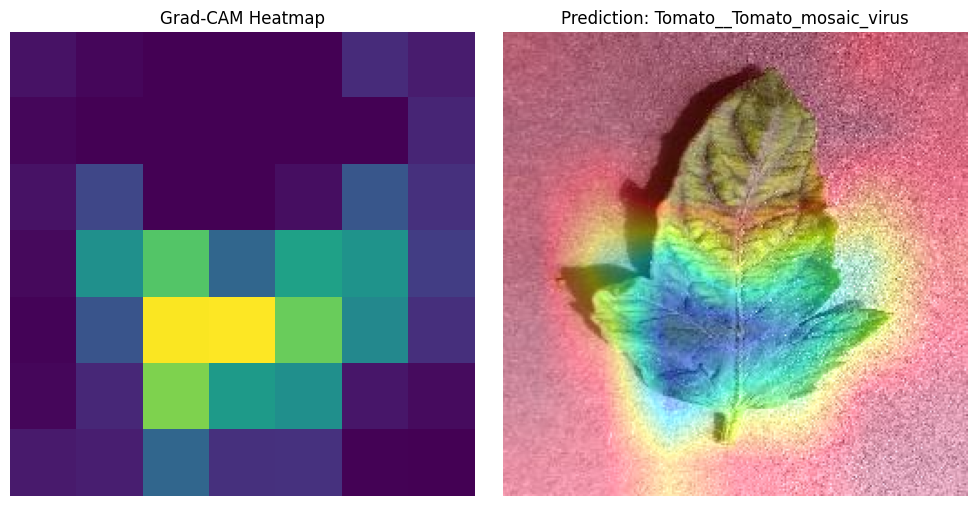

------------------------------------------------------------

--- CELL 4: PSEUDO-MASK DATASET CREATION ---
--- Setting segmentation data path ---
✅ Using existing segmentation data at: /content/drive/MyDrive/ML Project/segmentation_data
Proceeding with existing data.
------------------------------------------------------------

--- CELL 5: U-NET MODEL, LOSS, & DATA GENERATOR ---
✅ U-Net definitions loaded.
------------------------------------------------------------

--- CELL 6: TRAIN U-NET MODEL ---

Step 4: Training U-Net Segmentation Model
Using 4442 matching files.
Using 1829 matching files.

📊 Data loaded:
   Training batches: 138
   Validation batches: 57

🏗️  U-Net Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 224, 224,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ dropout_1[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 112, 112,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      9,248 │ dropout_2[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 56, 56,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ dropout_3[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 112, 112,  │      8,224 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112, 112,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 112, 112,  │     18,464 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 112, 112,  │          0 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │      9,248 │ dropout_4[0][0] 

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Starting U-Net training...
⏱️  This will take some time. Recommended: 15-25 epochs for best results
Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2395s 17s/step - accuracy: 0.2391 - dice_coefficient: 0.3762 - loss: 0.6238 - val_accuracy: 0.2379 - val_dice_coefficient: 0.3839 - val_loss: 0.6161
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 78s 564ms/step - accuracy: 0.2375 - dice_coefficient: 0.3834 - loss: 0.6166 - val_accuracy: 0.2379 - val_dice_coefficient: 0.3839 - val_loss: 0.6161
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 77s 560ms/step - accuracy: 0.2378 - dice_coefficient: 0.3838 - loss: 0.6162 - val_accuracy: 0.2379 - val_dice_coefficient: 0.3839 - val_loss: 0.6161
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 79s 570ms/step - accuracy: 0.2393 - dice_coefficient: 0.3848 - loss: 0.6152 - val_accuracy: 0.3571 - val_dice_coefficient: 0.4123 - val_loss: 0.5877
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 77s 560ms/step - accuracy: 0.3451 - dice_coefficient: 0.3999 - loss: 0.6001 - val_accuracy: 0.3454 - 


✅ U-Net training complete!

💾 Saving U-Net model to: /content/drive/MyDrive/ML Project/saved_models/unet_segmentation_model.h5
✅ Model saved successfully!
------------------------------------------------------------

--- CELL 7: PLOT TRAINING HISTORY ---

Step 5: Plotting Training History


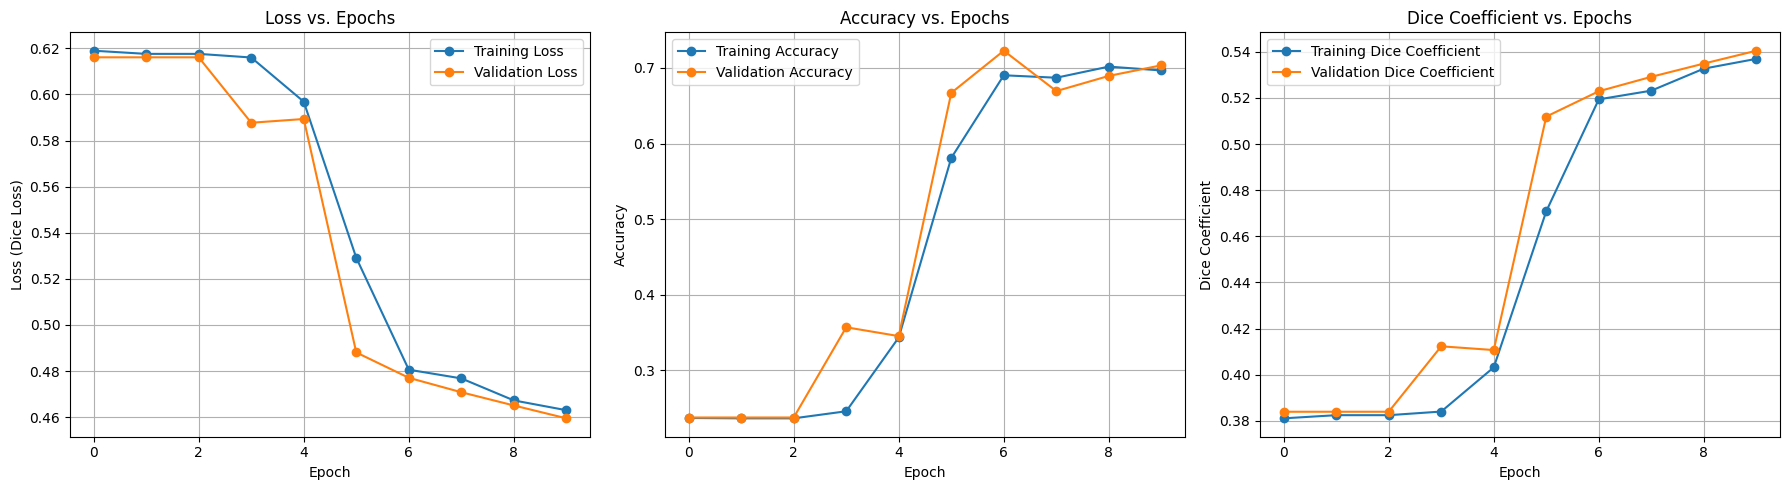

------------------------------------------------------------

--- CELL 8: TEST PREDICTIONS & FINAL SUMMARY ---

Step 6: Testing Disease Severity Prediction

🧪 Testing on 3 validation images...


--- Sample 1 ---
📊 Severity Score: 35.42%


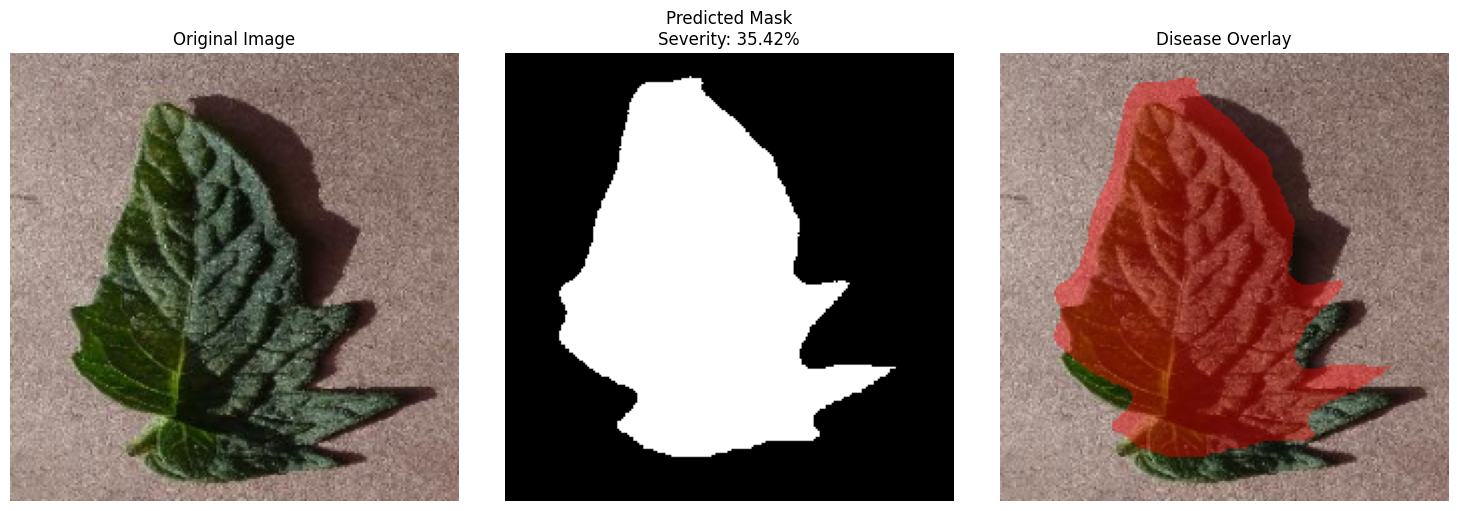


--- Sample 2 ---
📊 Severity Score: 48.27%


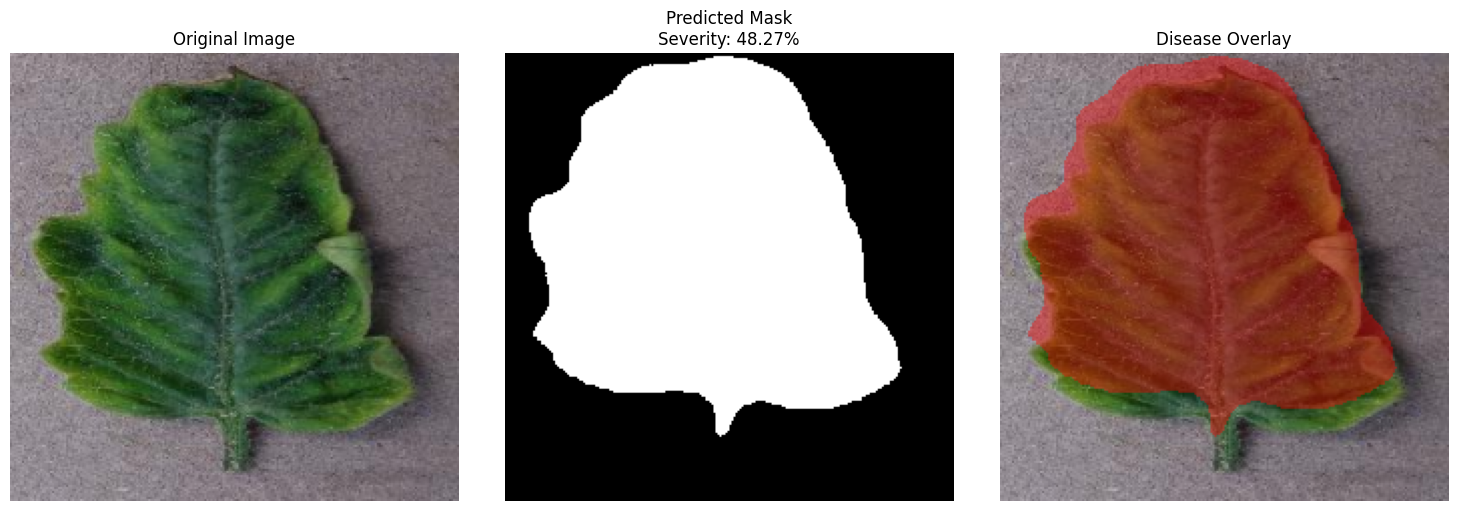


--- Sample 3 ---
📊 Severity Score: 39.28%


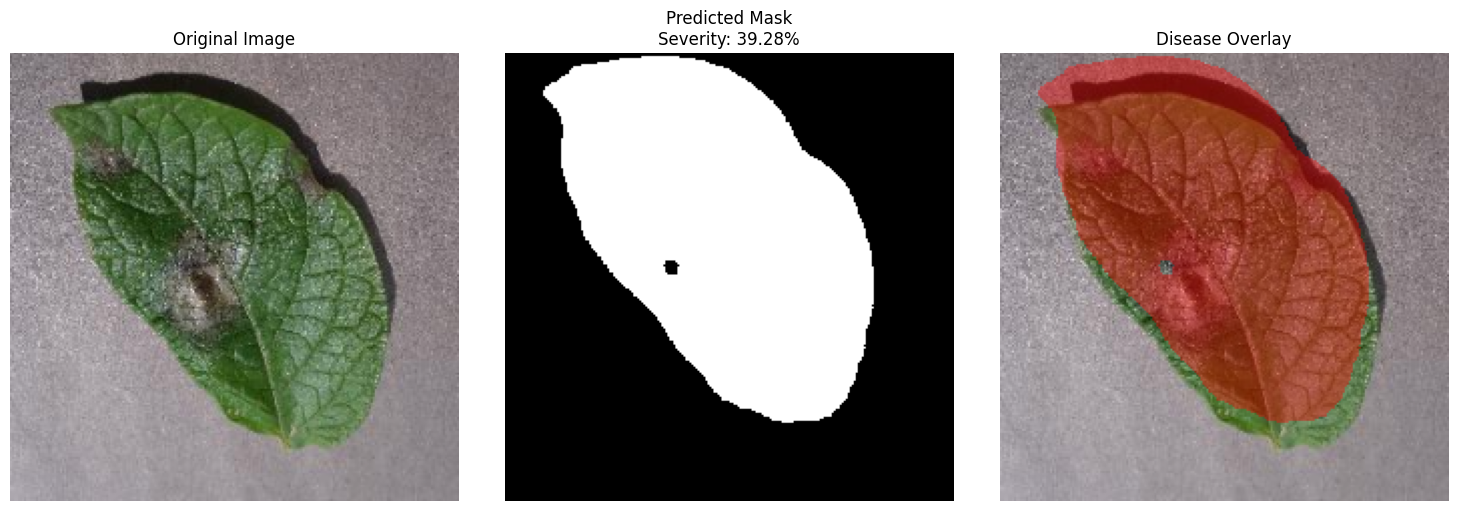



🎉 PIPELINE COMPLETE!
✅ Classification accuracy: 87.05%
✅ U-Net model: Trained and saved
✅ Severity prediction: Working

📁 All models saved in: /content/drive/MyDrive/ML Project/saved_models
📁 Segmentation dataset saved in: /content/drive/MyDrive/ML Project/segmentation_data


In [1]:
# Plant Disease Localization - Full Pipeline (Colab Notebook)
# This script is divided into cells for easy execution in Google Colab.
# Run each cell sequentially.

# ==============================================================================
# CELL 1: IMPORTS & SETUP
# ==============================================================================
print("--- CELL 1: IMPORTS & SETUP ---")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
from google.colab import drive
import json
import zipfile # <-- Added for unzipping

print("TensorFlow Version:", tf.__version__)

# Mount Google Drive
print("--- Mounting Google Drive ---")
try:
    drive.mount('/content/drive')
    print("✅ Drive mounted successfully.")
except Exception as e:
    print(f"❌ Error mounting Drive: {e}")

# --- Paths ---
# We will save models and the generated dataset to your MyDrive
base_drive_dir = '/content/drive/MyDrive/ML Project'
model_save_dir = os.path.join(base_drive_dir, 'saved_models')
segmentation_data_dir_drive = os.path.join(base_drive_dir, 'segmentation_data')

# --- MODIFICATION ---
# Path to the zip file on Google Drive
zip_file_path = os.path.join(base_drive_dir, 'archive.zip')

# Destination for unzipping in Colab's temporary storage
local_extract_path = './plant_disease_dataset'

# The 'image_dir' will be inside the unzipped folder.
# We assume the zip file contains a 'PlantVillage' folder.
image_dir = os.path.join(local_extract_path, 'PlantVillage')

print(f"Checking for dataset at: {image_dir}")

# Unzip the dataset if it's not already extracted
if not os.path.exists(image_dir):
    print(f"Dataset not found locally. Unzipping from: {zip_file_path}")
    if not os.path.exists(zip_file_path):
        print(f"❌ ERROR: Zip file not found at {zip_file_path}")
        print("Please ensure 'archive.zip' is in your '/content/drive/MyDrive/ML Project/' folder.")
    else:
        try:
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(local_extract_path)
            print(f"✅ Dataset successfully unzipped to {local_extract_path}")
        except Exception as e:
            print(f"❌ Error unzipping file: {e}")
else:
    print("✅ Dataset already unzipped locally.")


# Ensure other drive directories exist
os.makedirs(model_save_dir, exist_ok=True)
os.makedirs(segmentation_data_dir_drive, exist_ok=True)

# --- Constants ---
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 32

print(f"✅ Setup complete. Models will save to: {model_save_dir}")
print(f"✅ Segmentation dataset will save to: {segmentation_data_dir_drive}")
print(f"❗ Original dataset loaded from: {zip_file_path}")
print(f"❗ Using unzipped dataset at: {image_dir}")
print("-" * 60 + "\n")


# ==============================================================================
# CELL 2: LOAD CLASSIFICATION MODEL & CHECK ACCURACY
# ==============================================================================
print("--- CELL 2: LOAD CLASSIFICATION MODEL & CHECK ACCURACY ---")

classification_model_path = os.path.join(model_save_dir, 'classification_model.h5')

if not os.path.exists(classification_model_path):
    print(f"❌ Model not found at: {classification_model_path}")
    print("Please train the classification model first and save it to this location!")
    # In a real notebook, you'd stop execution here.
    # raise FileNotFoundError("Classification model not found")
else:
    print(f"✅ Loading classification model from: {classification_model_path}")
    classification_model = keras.models.load_model(classification_model_path)
    print("✅ Classification model loaded successfully!")

    # Get base model for Grad-CAM
    try:
        base_model = classification_model.get_layer('mobilenetv2_1.00_224')
        print(f"✅ Base model extracted: {base_model.name}")
    except ValueError as e:
        print(f"❌ Error getting base model layer: {e}")
        print("Please ensure your model's base layer is named 'mobilenetv2_1.00_224'")
        base_model = None

    # --- Check Model Accuracy ---
    print("\n" + "="*60)
    print("📊 CHECKING MODEL ACCURACY")
    print("="*60)

    # This check will now correctly look in the local unzipped folder
    if not os.path.exists(image_dir):
        print(f"❌ Dataset directory not found at: {image_dir}")
        print(f"Unzipping in CELL 1 might have failed or the zip file might not contain a 'PlantVillage' folder.")
    else:
        val_datagen = ImageDataGenerator(rescale=1./255)
        val_generator = val_datagen.flow_from_directory(
            image_dir,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False
        )

        class_indices = val_generator.class_indices
        print(f"\n📂 Found {len(class_indices)} classes.")

        # Save class indices
        class_indices_path = os.path.join(model_save_dir, 'class_indices.json')
        with open(class_indices_path, 'w') as f:
            json.dump(class_indices, f, indent=2)
        print(f"✅ Class indices saved to {class_indices_path}")

        # Evaluate model
        print("\n🔍 Evaluating model (this may take a few minutes)...")
        loss, accuracy = classification_model.evaluate(val_generator, verbose=1)

        print(f"\n{'='*60}")
        print(f"📊 CLASSIFICATION MODEL PERFORMANCE:")
        print(f"{'='*60}")
        print(f"  Loss:     {loss:.4f}")
        print(f"  Accuracy: {accuracy*100:.2f}%")
        print(f"{'='*60}")

print("-" * 60 + "\n")


# ==============================================================================
# CELL 3: GRAD-CAM FUNCTIONS & TEST
# ==============================================================================
print("--- CELL 3: GRAD-CAM FUNCTIONS & TEST ---")

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_layer_name):
    """
    Grad-CAM for loaded models - Uses layer output watching
    """
    try:
        base_model = model.get_layer('mobilenetv2_1.00_224')
    except Exception as e:
        print(f"Error getting base_model in Grad-CAM: {e}")
        return None, None

    with tf.GradientTape() as tape:
        base_output = base_model(img_array, training=False)
        tape.watch(base_output)

        x = tf.keras.layers.GlobalAveragePooling2D()(base_output)
        x = tf.keras.layers.Dropout(0.2)(x, training=False)

        dense_layer = model.get_layer(pred_layer_name)
        predictions = dense_layer(x)

        pred_index = tf.argmax(predictions[0])
        class_score = predictions[:, pred_index]

    grads = tape.gradient(class_score, base_output)
    if grads is None:
        print("Error: Gradients are None. Check model architecture.")
        return None, pred_index.numpy()

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    base_output = base_output[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[0]):
        base_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(base_output, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()

    return heatmap, pred_index.numpy()

def superimpose_heatmap(img_path, heatmap, alpha=0.4):
    """Overlay heatmap on original image"""
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

# --- Test Grad-CAM ---
if 'base_model' in locals() and base_model is not None and 'classification_model' in locals():
    print("\n--- Setting up Grad-CAM ---")
    last_conv_layer_name = None
    for layer in reversed(base_model.layers):
        if isinstance(layer, layers.Conv2D):
            last_conv_layer_name = layer.name
            break

    if last_conv_layer_name:
        print(f"✅ Using last conv layer: {last_conv_layer_name}")
        pred_layer_name = 'predictions'

        sample_img_path = None
        if os.path.exists(image_dir):
            for root, dirs, files in os.walk(image_dir):
                if files:
                    for f in files:
                        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                            sample_img_path = os.path.join(root, f)
                            break
                    if sample_img_path:
                        break

        if sample_img_path:
            print(f"\n🔬 Testing Grad-CAM on sample image: {sample_img_path}")
            img = keras.preprocessing.image.load_img(sample_img_path, target_size=(IMG_SIZE, IMG_SIZE))
            img_array = keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            heatmap, pred_index = get_gradcam_heatmap(img_array, classification_model,
                                                        last_conv_layer_name, pred_layer_name)

            if heatmap is not None and 'class_indices' in locals():
                class_name = [k for k, v in class_indices.items() if v == pred_index][0]
                print(f"✅ Predicted class: {class_name}")

                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(heatmap, cmap='viridis')
                plt.title("Grad-CAM Heatmap")
                plt.axis('off')

                superimposed = superimpose_heatmap(sample_img_path, heatmap)
                plt.subplot(1, 2, 2)
                plt.imshow(superimposed)
                plt.title(f"Prediction: {class_name}")
                plt.axis('off')
                plt.tight_layout()
                plt.show()
            else:
                print("❌ Could not generate Grad-CAM heatmap.")
        else:
            print(f"❌ No sample image found to test Grad-CAM in {image_dir}.")
    else:
        print("❌ Could not find a Conv2D layer in the base model.")
else:
    print("Skipping Grad-CAM test (model not loaded).")

print("-" * 60 + "\n")


# ==============================================================================
# CELL 4: PSEUDO-MASK DATASET CREATION
# ==============================================================================
print("--- CELL 4: PSEUDO-MASK DATASET CREATION ---")

def create_segmentation_dataset(image_dir, classification_model, class_indices,
                                last_conv_layer_name, pred_layer_name,
                                base_seg_dir): # <-- Pass in the new Drive path
    print("\n" + "="*60)
    print("Step 3: Creating Pseudo-Mask Dataset")
    print(f"Saving to: {base_seg_dir}")
    print("="*60)

    train_img_dir = os.path.join(base_seg_dir, 'train', 'images')
    train_mask_dir = os.path.join(base_seg_dir, 'train', 'masks')
    val_img_dir = os.path.join(base_seg_dir, 'val', 'images')
    val_mask_dir = os.path.join(base_seg_dir, 'val', 'masks')

    if not os.path.exists(image_dir):
        print(f"❌ Source image directory not found: {image_dir}")
        return None

    # Check if already exists in Drive
    if os.path.exists(train_img_dir) and len(os.listdir(train_img_dir)) > 100:
        train_count = len(os.listdir(train_img_dir))
        val_count = len(os.listdir(val_img_dir))
        print(f"\n✅ Dataset already exists in Drive!")
        print(f"   Train images: {train_count}")
        print(f"   Val images: {val_count}")

        # In Colab, we can't use input() easily. We'll add a flag.
        # Set this to True in your notebook to force regeneration.
        FORCE_REGENERATE = False
        if not FORCE_REGENERATE:
            print("✅ Using existing dataset. Set FORCE_REGENERATE = True to overwrite.")
            return base_seg_dir
        print("⚠️ FORCE_REGENERATE is True. Recreating dataset...")

    # Create directories
    for d in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir]:
        if os.path.exists(d):
            shutil.rmtree(d)
        os.makedirs(d)

    all_image_paths = []
    for subdir, _, files in os.walk(image_dir):
        class_name = os.path.basename(subdir)
        if class_name in class_indices:
            for f in files:
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_image_paths.append((os.path.join(subdir, f), class_name))

    np.random.seed(42)
    np.random.shuffle(all_image_paths)
    split_idx = int(len(all_image_paths) * 0.8)
    train_paths = all_image_paths[:split_idx]
    val_paths = all_image_paths[split_idx:]

    print(f"\n📊 Dataset split:")
    print(f"   Total images: {len(all_image_paths)}")
    print(f"   Training: {len(train_paths)}")
    print(f"   Validation: {len(val_paths)}")

    healthy_class_names = [name for name in class_indices.keys() if 'healthy' in name.lower()]
    print(f"\n🌿 Healthy classes found: {len(healthy_class_names)}")

    def process_and_save(image_paths, img_dir, mask_dir, split_name):
        count = 0
        errors = 0
        print(f"\n🔄 Processing {split_name} set...")

        total_paths = len(image_paths)
        for idx, (img_path, class_name) in enumerate(image_paths):
            try:
                img = keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                img_array = keras.preprocessing.image.img_to_array(img)
                img_array_rescaled = np.expand_dims(img_array, axis=0) / 255.0

                if class_name in healthy_class_names:
                    mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
                else:
                    heatmap, _ = get_gradcam_heatmap(img_array_rescaled, classification_model,
                                                     last_conv_layer_name, pred_layer_name)
                    if heatmap is None:
                        errors += 1
                        continue

                    heatmap_8bit = np.uint8(255 * heatmap)
                    _, mask = cv2.threshold(heatmap_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

                base_filename = f"img_{count:05d}.png"
                original_img = cv2.imread(img_path)
                if original_img is None:
                    errors += 1
                    continue

                original_img = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))
                cv2.imwrite(os.path.join(img_dir, base_filename), original_img)
                cv2.imwrite(os.path.join(mask_dir, base_filename), mask)

                count += 1

                if (idx + 1) % 100 == 0 or (idx + 1) == total_paths:
                    progress = (idx + 1) / total_paths * 100
                    print(f"   Progress: {progress:6.2f}% ({idx + 1}/{total_paths}) - {count} saved", end='\r')

            except Exception as e:
                print(f"Error on {img_path}: {e}")
                errors += 1

        print(f"\n✅ {split_name} complete: {count} images saved, {errors} errors.")
        return count

    train_count = process_and_save(train_paths, train_img_dir, train_mask_dir, "Training")
    val_count = process_and_save(val_paths, val_img_dir, val_mask_dir, "Validation")

    print(f"\n{'='*60}")
    print(f"✅ Dataset creation complete!")
    print(f"   Location: {base_seg_dir}")
    print(f"{'='*60}\n")
    return base_seg_dir

# --- Run Dataset Creation ---

# By default, we assume the data exists and set the path.
segmentation_data_dir = segmentation_data_dir_drive
print(f"--- Setting segmentation data path ---")

# We will set this to True only if we need to regenerate.
run_data_generation = False

# First, check if the data exists.
if (os.path.exists(segmentation_data_dir) and
    os.path.exists(os.path.join(segmentation_data_dir, 'train', 'images')) and
    len(os.listdir(os.path.join(segmentation_data_dir, 'train', 'images'))) > 0):

    print(f"✅ Using existing segmentation data at: {segmentation_data_dir}")
else:
    # If data is not found, print a warning.
    print(f"❌ WARNING: Segmentation data not found or empty at: {segmentation_data_dir}")

    # Check if we have the necessary components to generate it.
    if ('classification_model' in locals() and
        'class_indices' in locals() and
        'last_conv_layer_name' in locals() and last_conv_layer_name is not None):

        print("❗ Prerequisites for data generation are loaded.")
        print("Trying to regenerate data...")
        run_data_generation = True

    else:
        print("❌ Cannot regenerate data: classification_model, class_indices, or last_conv_layer_name not loaded.")
        print("Please run CELL 2 and CELL 3 first.")
        segmentation_data_dir = None # Set to None so training skips

# Run generation if the flag is set
if run_data_generation:
    print("Running create_segmentation_dataset...")
    segmentation_data_dir = create_segmentation_dataset(
        image_dir, classification_model, class_indices,
        last_conv_layer_name, pred_layer_name,
        segmentation_data_dir_drive # <-- Pass the Drive path
    )
elif segmentation_data_dir is not None:
     print("Proceeding with existing data.")
else:
     print("❌ Fatal error: No segmentation data available. Skipping subsequent steps.")


print("-" * 60 + "\n")


# ==============================================================================
# CELL 5: U-NET MODEL, LOSS, & DATA GENERATOR
# ==============================================================================
print("--- CELL 5: U-NET MODEL, LOSS, & DATA GENERATOR ---")

def build_unet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    """Builds U-Net segmentation model"""
    inputs = keras.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.1)(c7)
    c7 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

class SegmentationDataGenerator(keras.utils.Sequence):
    """
    Custom data generator for segmentation.
    Includes robust error handling and resizing to prevent ValueErrors.
    """
    def __init__(self, img_dir, mask_dir, batch_size, img_size, **kwargs):
        super().__init__(**kwargs)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size

        if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
            print(f"Error: Directory not found. Img: {img_dir}, Mask: {mask_dir}")
            self.img_filenames = []
            self.mask_filenames = []
            return

        self.img_filenames = sorted(os.listdir(img_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

        if len(self.img_filenames) != len(self.mask_filenames):
             print(f"Warning: Mismatch! {len(self.img_filenames)} images vs {len(self.mask_filenames)} masks")
             # Simple fix: use the minimum count
             min_count = min(len(self.img_filenames), len(self.mask_filenames))
             self.img_filenames = self.img_filenames[:min_count]
             self.mask_filenames = self.mask_filenames[:min_count]
             print(f"Using {min_count} matching files.")

    def __len__(self):
        return len(self.img_filenames) // self.batch_size

    def __getitem__(self, index):
        batch_img_paths = self.img_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_paths = self.mask_filenames[index * self.batch_size:(index + 1) * self.batch_size]

        batch_imgs = []
        batch_masks = []

        for img_name, mask_name in zip(batch_img_paths, batch_mask_paths):
            try:
                img_path = os.path.join(self.img_dir, img_name)
                mask_path = os.path.join(self.mask_dir, mask_name)

                # Read image
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Skipping corrupted or missing image: {img_path}")
                    continue

                # Read mask
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask is None:
                    print(f"Warning: Skipping corrupted or missing mask: {mask_path}")
                    continue

                # --- START: ROBUST RESIZING FIX ---
                # This guarantees all images/masks match the required size,
                # fixing the "inhomogeneous shape" ValueError.
                if img.shape[0] != self.img_size or img.shape[1] != self.img_size:
                    img = cv2.resize(img, (self.img_size, self.img_size), interpolation=cv2.INTER_AREA)

                if mask.shape[0] != self.img_size or mask.shape[1] != self.img_size:
                    mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)
                # --- END: ROBUST RESIZING FIX ---

                # Process image
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img / 255.0

                # Process mask
                mask = mask / 255.0
                mask = np.expand_dims(mask, axis=-1)

                # Final shape check
                if img.shape != (self.img_size, self.img_size, 3) or mask.shape != (self.img_size, self.img_size, 1):
                    print(f"Warning: Skipping sample with mismatched shapes. Img: {img.shape}, Mask: {mask.shape}")
                    continue

                batch_imgs.append(img)
                batch_masks.append(mask)

            except Exception as e:
                print(f"Error loading {img_name}: {e}. Skipping.")
                continue

        # Handle cases where the batch is empty after skipping files
        if not batch_imgs:
            print(f"Warning: Batch {index} is empty after processing. Returning zero-sized arrays.")
            return (
                np.zeros((0, self.img_size, self.img_size, 3), dtype=np.float32),
                np.zeros((0, self.img_size, self.img_size, 1), dtype=np.float32)
            )

        return np.array(batch_imgs, dtype=np.float32), np.array(batch_masks, dtype=np.float32)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

print("✅ U-Net definitions loaded.")
print("-" * 60 + "\n")


# ==============================================================================
# CELL 6: TRAIN U-NET MODEL
# ==============================================================================
print("--- CELL 6: TRAIN U-NET MODEL ---")

if segmentation_data_dir is not None and os.path.exists(segmentation_data_dir):
    print("\n" + "="*60)
    print("Step 4: Training U-Net Segmentation Model")
    print("="*60)

    # Create data generators
    train_gen = SegmentationDataGenerator(
        img_dir=os.path.join(segmentation_data_dir, 'train', 'images'),
        mask_dir=os.path.join(segmentation_data_dir, 'train', 'masks'),
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE
    )

    val_gen = SegmentationDataGenerator(
        img_dir=os.path.join(segmentation_data_dir, 'val', 'images'),
        mask_dir=os.path.join(segmentation_data_dir, 'val', 'masks'),
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE
    )

    print(f"\n📊 Data loaded:")
    print(f"   Training batches: {len(train_gen)}")
    print(f"   Validation batches: {len(val_gen)}")

    if len(train_gen) == 0 or len(val_gen) == 0:
        print("❌ Error: Not enough data to form batches. Check your dataset.")
    else:
        # Build U-Net
        unet_model = build_unet_model()
        unet_model.compile(
            optimizer='adam',
            loss=dice_loss,
            metrics=['accuracy', dice_coefficient]
        )

        print("\n🏗️  U-Net Architecture:")
        unet_model.summary()

        print("\n🚀 Starting U-Net training...")
        print("⏱️  This will take some time. Recommended: 15-25 epochs for best results")

        EPOCHS = 10 # Change this to 15-25 for better results

        history_unet = unet_model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=EPOCHS,
            verbose=1
        )

        print("\n✅ U-Net training complete!")

        # Save model
        unet_save_path = os.path.join(model_save_dir, 'unet_segmentation_model.h5')
        print(f"\n💾 Saving U-Net model to: {unet_save_path}")
        unet_model.save(unet_save_path)
        print("✅ Model saved successfully!")
else:
    print("❌ Skipping U-Net training (segmentation dataset not found).")
    history_unet = None

print("-" * 60 + "\n")


# ==============================================================================
# CELL 7: PLOT TRAINING HISTORY
# ==============================================================================
print("--- CELL 7: PLOT TRAINING HISTORY ---")

def plot_training_history(history):
    """Plots accuracy, loss, and dice coefficient from training history."""
    if history is None or not history.history:
        print("No training history to plot.")
        return

    print("\n" + "="*60)
    print("Step 5: Plotting Training History")
    print("="*60)

    # Check for available metrics
    metrics = list(history.history.keys())
    has_val = 'val_loss' in metrics

    # Plot Loss
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    if has_val:
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Dice Loss)')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    if has_val:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Dice Coefficient
    plt.subplot(1, 3, 3)
    plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient', marker='o')
    if has_val:
        plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient', marker='o')
    plt.title('Dice Coefficient vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- Plot the graphs ---
if 'history_unet' in locals() and history_unet is not None:
    plot_training_history(history_unet)
else:
    print("Skipping history plotting (training did not run).")

print("-" * 60 + "\n")


# ==============================================================================
# CELL 8: TEST PREDICTIONS & FINAL SUMMARY
# ==============================================================================
print("--- CELL 8: TEST PREDICTIONS & FINAL SUMMARY ---")

def predict_and_quantify(image_path, unet_model):
    """Predict disease mask and quantify severity"""
    try:
        img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array_rescaled = img_array / 255.0
        img_batch = np.expand_dims(img_array_rescaled, axis=0)

        pred_mask = unet_model.predict(img_batch, verbose=0)[0]
        pred_mask_binary = (pred_mask > 0.5).astype(np.uint8) * 255
        severity_percentage = np.mean(pred_mask) * 100

        print(f"📊 Severity Score: {severity_percentage:.2f}%")

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img_array.astype(np.uint8))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(pred_mask_binary.squeeze(), cmap='gray')
        plt.title(f"Predicted Mask\nSeverity: {severity_percentage:.2f}%")
        plt.axis('off')

        overlay = img_array.copy().astype(np.uint8)
        # Create a red color overlay
        mask_red_ch = np.zeros_like(img_array, dtype=np.uint8)
        mask_red_ch[..., 0] = 255 # Red channel

        # Get mask indices
        mask_indices = (pred_mask.squeeze() > 0.5)

        # Apply overlay only where mask is positive
        if np.any(mask_indices):
            overlay[mask_indices] = cv2.addWeighted(
                overlay[mask_indices], 0.6,
                mask_red_ch[mask_indices], 0.4, 0
            )

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title("Disease Overlay")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        return pred_mask, severity_percentage
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, 0

# --- Run Final Test ---

# Fix: If segmentation_data_dir is not defined (e.g., cell 4 was skipped),
# define it from the static path in CELL 1.
if 'segmentation_data_dir' not in locals() or segmentation_data_dir is None:
    print("⚠️ 'segmentation_data_dir' variable not found, trying static path from CELL 1.")
    segmentation_data_dir = segmentation_data_dir_drive # Path from CELL 1
    if not os.path.exists(segmentation_data_dir):
        print(f"❌ Static path {segmentation_data_dir} also not found. Run CELL 4.")
        segmentation_data_dir = None

# Fix: If unet_model is not defined (e.g., runtime reset), try to load it from Drive
# Note: This requires CELL 5 to be run first to define dice_loss/dice_coefficient
unet_save_path = os.path.join(model_save_dir, 'unet_segmentation_model.h5')
if 'unet_model' not in locals():
    print("⚠️ 'unet_model' variable not found, trying to load from Drive...")
    if os.path.exists(unet_save_path):
        try:
            # Check if loss functions are defined
            if 'dice_loss' not in locals() or 'dice_coefficient' not in locals():
                print("❌ 'dice_loss' or 'dice_coefficient' not defined. Please run CELL 5 first.")
                unet_model = None
            else:
                unet_model = keras.models.load_model(
                    unet_save_path,
                    custom_objects={'dice_loss': dice_loss, 'dice_coefficient': dice_coefficient}
                )
                print(f"✅ Successfully loaded U-Net model from: {unet_save_path}")
        except Exception as e:
            print(f"❌ Error loading U-Net model: {e}")
            unet_model = None
    else:
        print(f"❌ U-Net model not found at: {unet_save_path}. Run CELL 6 to train.")
        unet_model = None


if 'unet_model' in locals() and unet_model is not None and segmentation_data_dir is not None:
    print("\n" + "="*60)
    print("Step 6: Testing Disease Severity Prediction")
    print("="*60)

    val_img_dir = os.path.join(segmentation_data_dir, 'val', 'images')
    if os.path.exists(val_img_dir):
        val_images = sorted(os.listdir(val_img_dir))

        if val_images:
            print(f"\n🧪 Testing on {min(3, len(val_images))} validation images...\n")
            for i in range(min(3, len(val_images))):
                print(f"\n--- Sample {i+1} ---")
                sample_path = os.path.join(val_img_dir, val_images[i])
                _ = predict_and_quantify(sample_path, unet_model)
        else:
            print("❌ No validation images found to test.")
    else:
        print(f"❌ Validation image directory not found: {val_img_dir}")

else:
    print("Skipping final prediction test (U-Net model not trained).")


# --- Final Summary ---
print("\n\n" + "="*60)
print("🎉 PIPELINE COMPLETE!")
print("="*60)
if 'accuracy' in locals():
    print(f"✅ Classification accuracy: {accuracy*100:.2f}%")
if 'unet_model' in locals():
    print("✅ U-Net model: Trained and saved")
    print("✅ Severity prediction: Working")
print(f"\n📁 All models saved in: {model_save_dir}")
print(f"📁 Segmentation dataset saved in: {segmentation_data_dir_drive}")
print("="*60)

